In [32]:
import pandas as pd
import numpy as np

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

# 데이터 분할
X = train.drop(columns=['number_of_rentals', 'date_time'])
y = train['number_of_rentals']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링 (SVR은 스케일링 필수!)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_valid_scaled = scaler_X.transform(X_valid)
X_test_scaled = scaler_X.transform(test.drop(columns=['date_time']))

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # y도 스케일링!
y_valid_scaled = scaler_y.transform(y_valid.values.reshape(-1, 1)).ravel()

# 모델 학습 (커널을 'rbf'로 설정 - 비선형 모델)
svr_model = SVR(kernel='rbf', C=0.1, epsilon=0.3, gamma=0.001)
svr_model.fit(X_train_scaled, y_train_scaled)

# 예측
y_train_pred = svr_model.predict(X_train_scaled)
y_valid_pred = svr_model.predict(X_valid_scaled)
y_test_pred = svr_model.predict(X_test_scaled)

# 스케일링 원복 (평가를 위해)
y_train_pred_original = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).ravel()
y_valid_pred_original = scaler_y.inverse_transform(y_valid_pred.reshape(-1, 1)).ravel()
y_test_pred_original = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()

# NMAE 계산
nmae_train = mean_absolute_error(y_train, y_train_pred_original) / np.mean(y_train)
nmae_valid = mean_absolute_error(y_valid, y_valid_pred_original) / np.mean(y_valid)

print('train nmae:', nmae_train)
print('valid nmae:', nmae_valid)

# 결과를 submission 파일에 저장
submission["number_of_rentals"] = y_test_pred_original
submission.to_csv('SVR_submission.csv', index=False, encoding='utf-8-sig')


train nmae: 0.38464617640261595
valid nmae: 0.4360929992536518


In [34]:
import os
import pandas as pd

folder_path = r"c:\Users\김은교\OneDrive\바탕 화면\BRAIN\Dacon-project\bicycle_rentals_prediction"
file_list = os.listdir(folder_path)

for filename in file_list:
    file_path = os.path.join(folder_path, filename)
    try:
        if filename.endswith(".txt"):
            with open(file_path, "r", encoding="utf-8") as file:
                content = file.read()
                print(content[:200])  # 앞부분만 출력

        elif filename.endswith(".csv"):
            df = pd.read_csv(file_path, encoding="utf-8")
            print(df.head())

        else:
            print(f"Skipping unsupported file type: {filename}")

    except PermissionError:
        print(f"Permission denied: {file_path}")
    except IsADirectoryError:
        print(f"Skipping directory: {file_path}")
    except UnicodeDecodeError:
        print(f"Encoding error: {file_path}")


Skipping unsupported file type: .ipynb_checkpoints
Skipping unsupported file type: 1차
Skipping unsupported file type: 2조_멘티.pdf
    date_time  number_of_rentals
0  2021-04-01       40794.474573
1  2021-04-02       35584.415451
2  2021-04-03       33357.655951
3  2021-04-04       31480.311211
4  2021-04-05       64507.239850
Skipping unsupported file type: lasso.ipynb
Skipping unsupported file type: linear regression.ipynb
Skipping unsupported file type: model selection(1).ipynb
Skipping unsupported file type: ridge.ipynb
    date_time  number_of_rentals
0  2021-04-01                  0
1  2021-04-02                  0
2  2021-04-03                  0
3  2021-04-04                  0
4  2021-04-05                  0
    date_time  number_of_rentals
0  2021-04-01       53712.883548
1  2021-04-02       34630.063757
2  2021-04-03       25172.389198
3  2021-04-04       29214.139923
4  2021-04-05       58774.356557
Skipping unsupported file type: SVR.ipynb
    date_time  number_of_rentals
0 

In [35]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 5, 10],
    'epsilon': [0.1, 0.2, 0.3],
    'gamma': [0.001, 0.01, 'scale']
}

from sklearn.metrics import make_scorer

def nmae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred) / np.mean(y_true)
nmae_scorer = make_scorer(nmae, greater_is_better=False) # NMAE가 작을수록 좋음

grid = GridSearchCV(SVR(kernel='rbf'), param_grid, scoring=nmae_scorer, cv=5, n_jobs=1)
grid.fit(X_train_scaled, y_train_scaled)

print("Best params:", grid.best_params_)


Best params: {'C': 0.1, 'epsilon': 0.3, 'gamma': 0.001}


In [36]:
import os
print(os.getcwd())


c:\Users\김은교\OneDrive\바탕 화면\BRAIN\Dacon-project\bicycle_rentals_prediction


In [45]:
import matplotlib.pyplot as plt

df=pd.read_csv('모델 평가.csv', encoding='utf-8-sig')
df.head()

,model,train nmae,valid nmae
0,Linear regression,0.305115,0.302117
1,Linear regression_scaled,0.305115,0.302117
2,Linear regression_scaled_reduction,0.315270,0.301297
3,Lasso_alpha0.1,0.305115,0.302115
4,Lasso_alpha0.01,0.305115,0.302117


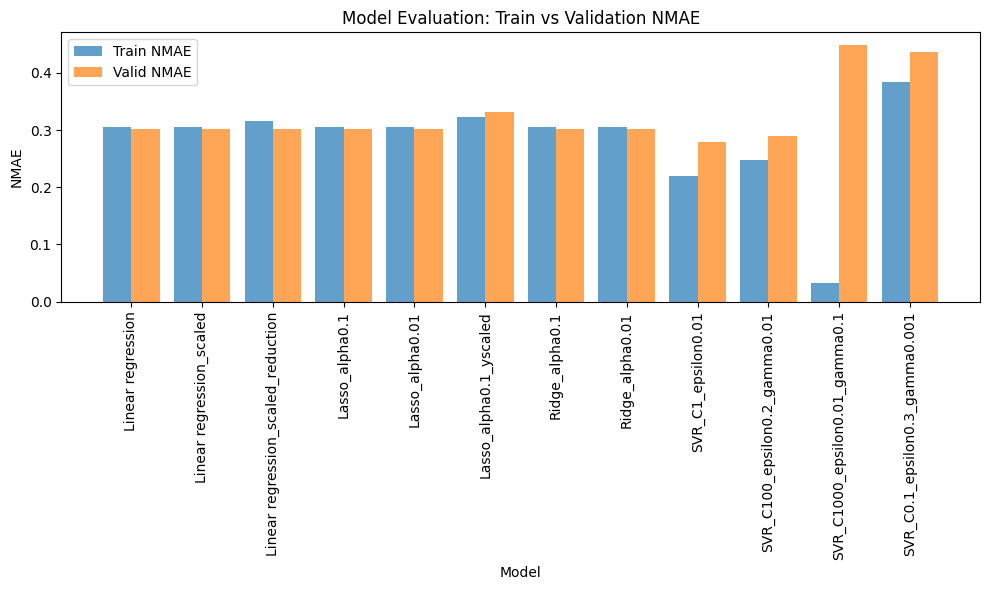

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 읽기
df = pd.read_csv('모델 평가.csv')

# 데이터 선택
models = df['model']
train_nmae = df['train nmae']
valid_nmae = df['valid nmae']

# 그래프 그리기
x = range(len(models))
plt.figure(figsize=(10, 6))
plt.bar(x, train_nmae, width=0.4, label='Train NMAE', align='center', alpha=0.7)
plt.bar([p + 0.4 for p in x], valid_nmae, width=0.4, label='Valid NMAE', alpha=0.7)

# 그래프 꾸미기
plt.xticks([p + 0.2 for p in x], models, rotation=90)
plt.xlabel('Model')
plt.ylabel('NMAE')
plt.title('Model Evaluation: Train vs Validation NMAE')
plt.legend()

plt.tight_layout()
plt.show()